In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

Get and Preprocess Dataset


In [2]:
df = pd.read_csv('./total_relations.csv')
print(df.shape)
df.head()

(29339, 5)


,nucleus,satellite,relation,word_count,converted_relation
0,Aesthetic Appreciation and Spanish Art :,Insights from Eye - Tracking,elaboration-additional,14,Elaboration
1,Claire Bailey - Ross claire.bailey-ross@port.a...,Aesthetic Appreciation and Spanish Art : Insig...,organization-heading,755,Textual-Organization
2,Claire Bailey - Ross claire.bailey-ross@port.a...,Andrew Beresford a.m.beresford@durham.ac.uk Du...,joint-list,38,Joint
3,Andrew Beresford a.m.beresford@durham.ac.uk Du...,Daniel Smith daniel.smith2@durham.ac.uk Durham...,joint-list,27,Joint
4,Daniel Smith daniel.smith2@durham.ac.uk Durham...,Claire Warwick c.l.h.warwick@durham.ac.uk Durh...,joint-list,19,Joint


In [3]:
df_switch = df.copy() # swith positions of nucleus and satellite
df_switch.rename(columns={'nucleus': 'satellite', 'satellite': 'nucleus'}, inplace=True)

In [4]:
combined_df = pd.concat([df, df_switch], ignore_index=True)

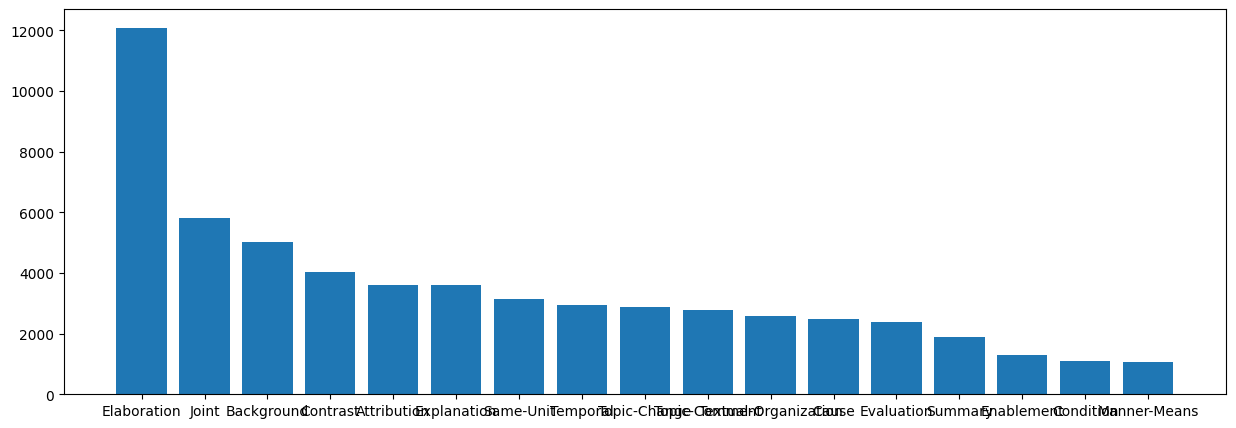

In [5]:
plt.figure(figsize=(15, 5))
plt.bar(x=list(combined_df.converted_relation.value_counts().keys()), height=list(combined_df.converted_relation.value_counts().values))
plt.show()

In [15]:
# helper
for r in df[df.converted_relation == 'Enablement'].iterrows():
    if len(r[1].nucleus.split(' ')) < 15 and len(r[1].satellite.split(' ')) < 15:
        print(r[1].nucleus)
        print(r[1].satellite)
        print()

required 
to do this task by hand 

This system can also be used longitudinally 
to study how the workforce ’s composition changes over time , 

and uses the 2011 and 2017 censuses 
to investigate the “ leaky pipeline ” problem in faculty retention . 

two additional demographic variables are included . 
To provide information on the analytical sample as a whole , 

one must have adequate knowledge of the focal country ’s institutional framework . 
In order to understand policymaking and its effects , 

Speakers of Eegimaa use the term Gújjolaay ( meaning Jóola ) 
to refer to their language 

but Eegimaa 
to distinguish their Jóola variety from that of other Jóola peoples . 

and whether lexical and syntactic criteria are sufficient 
to identify enjambment . 

Systematically collecting large amounts of enjambment examples provides helpful evidence 
to assess scholars ’ current claims , 

what kinds of knowledge they must utilize 
to guide their selection of sources 

The companies hope

In [77]:
# adding <sep> token between nucleus and satellite
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

separation_token = tokenizer.sep_token
input_sentences = combined_df.apply(lambda x: ''.join([x['nucleus'], separation_token, x['satellite']]), axis=1)
np.array(input_sentences)
input_sentences[500]

'Language names are written following the recommendation for the transcription of national languages of Senegal , Decree 2005-981 . [SEP]Names of the villages of Mof-Ávvi are written using the Eegimaa orthography and following the pronunciation of village names by native speakers . '

In [81]:
# tokenizer
def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding=True, truncation=True)

In [82]:
# get labels, dataset now is (input_sentences, labels)
from sklearn.preprocessing import LabelEncoder

labels = combined_df.converted_relation
le = LabelEncoder()
labels = le.fit_transform(labels)
le.classes_

array(['Attribution', 'Background', 'Cause', 'Condition', 'Contrast',
       'Elaboration', 'Enablement', 'Evaluation', 'Explanation', 'Joint',
       'Manner-Means', 'Same-Unit', 'Summary', 'Temporal',
       'Textual-Organization', 'Topic-Change', 'Topic-Comment'],
      dtype=object)

In [83]:
# merge input sentence and labels onto one list (to form dataset object later)
data = []
for text, label in zip(input_sentences, labels):
    datapoint = {'text': text, 'label': label}
    data.append(datapoint)
data = np.array(data)

In [84]:
# split train/test set while preserving class distribution
# access split data like this: for i, (train_index, test_index) in enumerate(sss.split(X, y)):
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
stk = StratifiedKFold(n_splits=5)
data_split = stk.split(input_sentences, labels)

Prepare for Training


In [85]:
def freeze_encoder_layers(model, num_frozen_layers):
  """Freezes the first `num_frozen_layers` of DeBERTa model.

  Args:
      model: The DeBERTa model to be fine-tuned.
      num_frozen_layers: The number of layers to freeze.
  """
  for name, param in model.named_parameters():
    if name.startswith("deberta.encoder.layer.") and int(name.split(".")[3]) < num_frozen_layers:
      param.requires_grad = False

In [86]:
def freeze_embeddings_layers(model):
  """Freezes all embeddings-related layers of DeBERTa model. (no option for number of layers 'cause there's only one)

  Args:
      model: The DeBERTa model to be fine-tuned.
  """
  for name, param in model.named_parameters():
    if name.startswith("deberta.embeddings."):
      param.requires_grad = False

In [87]:
# freeze_encoder_layers(model, 12)
# freeze_embeddings_layers(model)

In [88]:
# for name, param in model.named_parameters():
#     print(param.requires_grad, '-', name)         

IDEAS:

- nucleus and satellites currently sometimes have mixed order. May try to find a way to fix that.
- separting nucleus and satellites from context may deprive certain information.


Trainer


In [89]:
# metric
import evaluate

metric = evaluate.load('f1')
def compute_metrics(eval_pred): 
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='macro')

In [91]:
import datasets
from transformers import Trainer
from transformers import TrainingArguments

log_history = []
for fold_number, (train_index, test_index) in enumerate(data_split):
    train_data = data[train_index]
    test_data = data[test_index]

    train_set = datasets.Dataset.from_list(list(train_data))
    test_set = datasets.Dataset.from_list(list(test_data))

    tokenized_train_set = train_set.map(tokenize_function, batched=True)
    tokenized_test_set = test_set.map(tokenize_function, batched=True)
    
    cur_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", 
                                                                    num_labels=17)
    cur_model.to(torch.device('cuda'))

    # training args
    training_args = TrainingArguments(
    output_dir=f"./output_train_all_with_additional_reverse_dataset{fold_number + 1}", 
    learning_rate=4e-6,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=5,
    save_total_limit=3,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_steps=1500,
    eval_steps=1500)

    # trainer object to perfrom training-related tasks
    trainer = Trainer(
    model=cur_model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics)

    trainer.train()

    log_history.append(trainer.state.log_history)

    eval_results = trainer.evaluate(eval_dataset=tokenized_test_set)
    print("Score at fold:", fold_number, ":", eval_results, '\n')

Map: 100%|██████████| 11736/11736 [00:01<00:00, 6238.84 examples/s]
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/e/TOM/HUST/20232/rst-relations-labeller/.venv/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,F1
1500,2.121900,2.054280,0.234579
3000,1.652100,1.622723,0.407772
4500,1.416100,1.425467,0.504743
6000,1.306400,1.304549,0.558715
7500,1.178500,1.197201,0.613545
9000,1.141900,1.175288,0.619110
10500,1.015000,1.179284,0.631917
12000,0.970300,1.107243,0.648258
13500,0.986000,1.066303,0.661816
15000,0.947100,1.068191,0.663885


Score at fold: 0 : {'eval_loss': 0.9151063561439514, 'eval_f1': 0.750169557019159, 'eval_runtime': 406.1881, 'eval_samples_per_second': 28.893, 'eval_steps_per_second': 5.781, 'epoch': 5.0} 



Map: 100%|██████████| 11736/11736 [00:01<00:00, 6362.36 examples/s]
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/e/TOM/HUST/20232/rst-relations-labeller/.venv/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,F1
1500,2.165000,2.172863,0.198610
3000,1.705500,1.642696,0.404554
4500,1.441900,1.400348,0.499490


KeyboardInterrupt: 

Currently Training with Reverse Dataset attached (nucleus and satellite switched place). Next design the dataset so that both version of a nucleus-satallite pair only belongs to either the traning or test set, to prevent data leakage.


Evaluation


In [20]:
# result of training on fold 1 eval on fold 1 
eval_results = trainer.evaluate(eval_dataset=tokenized_test_set)
eval_results

{'eval_loss': 2.633216381072998, 'eval_f1': 0.020098247013939106}

Inference


In [95]:
device = 'cuda'
sample_n = """To work out the evolutionary history, development and relationships among groups of organisms,"""
sample_s = """biologists compare the characteristics of living species in a process called phylogenetic analysis"""
sample = sample_n + separation_token + sample_s

with torch.no_grad():
    tokens = tokenizer(sample, padding=True, truncation=True, return_tensors='pt').to(device)
    output = cur_model(**tokens)
    
logits = output.logits
logits = torch.Tensor.cpu(logits)
prediction = int(np.argmax(logits))
label = le.classes_[prediction]
print("Sentence:", sample)
print("Label:", label)  

Sentence: To work out the evolutionary history, development and relationships among groups of organisms,[SEP]biologists compare the characteristics of living species in a process called phylogenetic analysis
Label: Enablement


Helper Blocks


End Helper Blocks
